In [12]:
from typing import Dict, List, Union, Tuple
from collections import namedtuple, defaultdict
from copy import deepcopy
from enum import Enum

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import os

TAG = "only-inserts-test4"

lower_bounds = [0.25]
upper_bounds = [4]

NUMEPOCHS = 12

INSERTS = 5000000
UPDATES = 0
RANGE_QUERIES = 0
SELECTIVITY = 0
SIZE_RATIO = 2
ENTRY_SIZE = 64  # E
ENTRIES_PER_PAGE = 64  # B
NUM_PAGE_PER_FILE = 64  # P

EXPDIRNAME = f"/home/cc/LSMQueryDrivenCompaction/development/rocksdb/examples/__working_branch/experiments-{TAG}-E{ENTRY_SIZE}-B{ENTRIES_PER_PAGE}-S{RANGE_QUERIES}-Y{SELECTIVITY}-T[{SIZE_RATIO}]"

In [13]:
def vanilla_dirname(comp: Dict[str, Union[int, float]], re: int=0) -> str:
    return (
        f"I {comp['inserts']} U {comp['updates']} S {comp['range']} Y {comp['selectivity']} "
        f"T {comp['sizeRatio']} rq 0 re {re} E {comp['entrySize']} B {comp['entriesPerPage']}"
    )

def rqdc_dirname(comp: Dict[str, Union[int, float]], re: int=0) -> str:
    return (
        f"I {comp['inserts']} U {comp['updates']} S {comp['range']} Y {comp['selectivity']} "
        f"T {comp['sizeRatio']} rq 1 re {re} E {comp['entrySize']} B {comp['entriesPerPage']} "
        f"lb {comp['lowerBound']} ub {comp['upperBound']}"
    )

In [14]:
PlottingStats = namedtuple(
    "PlottingStats",
    [
        "CompactionDebt",
        "WriteAmpDebt",
        "WriteAmpDebtFull",
        "WriteAmpDebtPartial",
        "AvgEntriesPerFile",
        "FilesCount",
        "DBSize",
        "ValidEntriesCount",
        "InvalidEntriesCount",
        "TotalWriteBytes",
        "CompactionReadBytes",
        "LevelsState",
    ],
)

class RQColumn(Enum):
    RQ_NUMBER="RQ Number",
    RQ_TOTAL_TIME="RQ Total Time",
    DATA_USEFUL_BYTES_WRITTEN="Data uBytes Written Back",
    TOTAL_USEFUL_BYTES_WRITTN="Total uBytes Written Back",
    USEFUL_ENTRIES_COUNT_WRITTEN="uEntries Count Written Back",
    TOTAL_ENTRIES_READ="Total Entries Read",
    DATA_UNUSEFUL_BYTES_WRITTEN="Data unBytes Written Back",
    TOTAL_UNUSEFUL_BYTES_WRITTEN="Total unBytes Written Back",
    UNUSEFUL_ENTRIES_COUNT_WRITTEN="unEntries Count Written Back",
    RQ_REFRESH_TIME="RQ Refresh Time",
    RQ_RESET_TIME="RQ Reset Time",
    RQ_TIME="Actual RQ Time",

    def __str__(self):
        return '%s' % self.value

In [15]:
class TimePoints:
    logfilename = "workload.log"
    keys = {
        "rocksdb.compact.write.bytes": "compact",
        "rocksdb.flush.write.bytes": "flush",
        "rocksdb.compaction.num.triggered": "numCompactions",
        "rocksdb.files.trivially.moved": "trivialMoves",
        "filesPerLevel": "filesPerLevel",
        "levels.state": "levelsState"
    }

    def _get_tp_key_value(self, line: str):
        ll = line.strip("\n \n ")
        items = ll.split(" ")
        tp = items[0].split("(")[1].strip(")")
        key = items[1].split(":")[0].strip(" ")

        if key == "levels.state":
            value = list([int(n) for n in items[2].strip(' \n , ').split(',')])
        else:
            value = int(items[2].strip(" "))
        return (tp, key, value)

    def _parse_logfile(self):
        self.flushes = defaultdict(dict)  # time_point -> {'compact': XX, 'flush': YY}
        self.compactions = defaultdict(
            dict
        )  # time_point -> {'compact': XX, 'flush': YY}

        print("processing file: ", self.filepath)
        ff = open(self.filepath)

        while line := ff.readline():
            if line.startswith("OnFlushCompleted") or line.startswith(
                "OnCompactionCompleted"
            ):
                tp, key, value = self._get_tp_key_value(line)

                if line.startswith("OnFlushCompleted"):
                    self.flushes[tp][self.keys[key]] = value
                elif line.startswith("OnCompactionCompleted"):
                    self.compactions[tp][self.keys[key]] = value

    def __init__(self, logdirpath: str):
        logfilepath = os.path.join(logdirpath, self.logfilename)

        if not os.path.exists(logdirpath) or not os.path.exists(logfilepath):
            if not os.path.exists(logdirpath):
                raise FileNotFoundError(f"log directory: {logdirpath} not found")
            raise FileNotFoundError(f"log file {logfilepath} not found")

        self.filepath = logfilepath
        self._parse_logfile()

    def get_flushes(self) -> Dict[str, Dict[str, int]]:
        return self.flushes

    def get_compactions(self) -> Dict[str, Dict[str, int]]:
        return self.compactions

In [16]:
class EpochStats:
    logfilename = 'workload.log'
    rangequery_stats_filename = 'range_queries.csv'

    def _compaction_debt(self, levels: Dict[str, List]) -> int:
        """
        assuming the levels is sorted by level 0, 1, ... L_n
        $ \text{CD} = \sum_{i=1}^{L_{n-1}} \text{Bytes} \left( L_i \right)$
        """
        sum_of_bytes = 0
        last_lvl_index = len(levels) - 1  # 0 indexed levels

        for lvl, data in enumerate(levels):
            if lvl == last_lvl_index or levels[lvl+1]['LevelSize'] == 0:
                break
            sum_of_bytes += data['LevelSize']
        
        return sum_of_bytes

    def _writeamp_debt(self, levels: Dict[str, List]) -> int:
        """
        assuming the levels is sorted by level 0, 1, ... L_n
        $ \text{WA} = \sum_{i=1}^{L_{n-1}} \text{Bytes} \left( L_i \right) \times (L_{n} - i) $
        """
        sum_of_bytes = 0
        last_lvl_index = len(levels) - 1 # 0 indexed levels
        last_non_empty_level_index = last_lvl_index

        for data in levels[::-1]:
            if data['LevelSize'] != 0:
                break
            last_non_empty_level_index -= 1

        for lvl, data in enumerate(levels):
            if lvl == last_non_empty_level_index:
                break
            sum_of_bytes += data['LevelSize'] * (last_non_empty_level_index - lvl)

        return sum_of_bytes

    def _writeampfull_debt(self, levels: Dict[str, List]) -> int:
        """
        assuming the levels is sorted by level 0, 1, ... L_n
        $ \text{WA\textsuperscript{L1}} = \text{Bytes}\left( L_1 \right) \times (L_{n} - 1)$\\
        $ \text{WA\textsuperscript{full}} = \text{WA\textsuperscript{L1}} + \sum_{i=2}^{L_{n}} \text{Bytes} \left( L_i \right) \times (L_{n} - i + 1) $
        """
        sum_of_bytes = 0
        last_lvl_index = len(levels) - 1 # 0 indexed levels
        last_non_empty_level_index = last_lvl_index

        for data in levels[::-1]:
            if data['LevelSize'] != 0:
                break
            last_non_empty_level_index -= 1

        for lvl, data in enumerate(levels):
            if lvl > last_non_empty_level_index:
                break
            if lvl == 0:
                sum_of_bytes += data['LevelSize'] * last_non_empty_level_index
            else:
                sum_of_bytes += data['LevelSize'] * (last_non_empty_level_index - lvl + 1)

        return sum_of_bytes

    def _writeamppartial_debt(self, levels: Dict[str, List], filesize: int) -> int:
        """
        assuming the levels is sorted by level 0, 1, ... L_n
        $ \text{File Size (FS)} = (P \times B)$ 
        $ \text{WA\textsuperscript{partial}} = WA^{partial} + (\sum_{i=2}^{L_{n}} \text{Bytes} \left( L_{i-1} \right)) - FS \times (L_{n} - 1)$        """
        sum_of_bytes = 0
        last_lvl_index = len(levels) - 1 # 0 indexed levels
        last_non_empty_level_index = last_lvl_index

        for data in levels[::-1]:
            if data['LevelSize'] != 0:
                break
            last_non_empty_level_index -= 1
        
        for lvl, data in enumerate(levels):
            if lvl > last_non_empty_level_index:
                break
            if lvl == 0:
                continue
            sum_of_bytes += levels[lvl-1]['LevelSize']

        return self._writeampfull_debt(levels) + (sum_of_bytes - (filesize * last_non_empty_level_index))

    def _total_write_bytes(self, epoch_stats: List[str]):
        write_bytes = 0

        for line in epoch_stats:
            if line.startswith('rocksdb.compact.write.bytes') or line.startswith('rocksdb.flush.write.bytes'):
                write_bytes += int(line.split(':')[1])
        
        return write_bytes

    def _compaction_read_bytes(self, epoch_stats: List[str]):
        read_bytes = 0

        for line in epoch_stats:
            if line.startswith("rocksdb.compact.read.bytes"):
                read_bytes += int(line.split(':')[1])
        
        return read_bytes

    def _read_one_epoch(self):
        with open(self.filepath, 'r') as file:
            epoch_data = list()
            grabbing_data = False

            for line in file:
                line = line.strip()
                if line.startswith("====================="):
                    if grabbing_data:
                        yield epoch_data
                        epoch_data = list()
                        grabbing_data = False
                elif grabbing_data:
                    epoch_data.append(line)
                else:
                    grabbing_data = True
                    epoch_data.append(line)

    def _parse_one_epoch(self, epoch_stats: List[str]) -> Dict[str, List]:
        columnfamilydata = {'Levels': list()}
        sst_files = {}
        i = 0

        while i < len(epoch_stats):
            currentline = epoch_stats[i]
            # Check if the line contains column family data
            if currentline.startswith("Column Family Name"):
                key_val = currentline.split(',')
                columnfamilydata["Column Family Name"] = key_val[0].split(':')[1].strip().strip(',')
                columnfamilydata["Size"] = int(key_val[1].split(':')[1].strip().strip(',').strip(' bytes'))
                columnfamilydata["Files Count"] = int(key_val[2].split(':')[1].strip().strip(','))
                columnfamilydata["Entries Count"] = int(key_val[3].split(':')[1].strip().strip(','))
                columnfamilydata["Invalid Entries Count"] = int(key_val[4].split(':')[1].strip().strip(','))                
            if "Level:" in currentline:
                key_val = currentline.strip().split(',')
                level = int(key_val[0].split(":")[1].strip().strip(','))
                level_size = int(key_val[1].split(':')[1].strip().strip(',').strip(' bytes'))
                level_files_count = int(key_val[2].split(':')[1].strip().strip(','))

                key_val_sst_files = epoch_stats[i+1].split('],')[:-1]
                sst_files = []
                
                for sst_file_string in key_val_sst_files:
                    # Extract SST file details
                    file_number = int(sst_file_string.split(":")[0].split("[#")[1].strip())
                    file_details = sst_file_string.split(":")[1].strip().split()
                    file_size = int(file_details[0].strip())
                    smallest_key = int(file_details[1].strip(',').strip('('))
                    largest_key = int(file_details[2].strip(')'))
                    entries_count = int(file_details[3].strip(']'))

                    sst_files.append({
                        "FNo": file_number,
                        "FileSize": file_size,
                        "SmallesKey": smallest_key,
                        "LargestKey": largest_key,
                        "EntriesCount": entries_count
                    })
                
                # if len(sst_files) > 0:
                columnfamilydata["Levels"].append({
                    "Level": level,
                    "LevelSize": level_size,
                    "LevelFilesCount": level_files_count,
                    "SSTFiles": sst_files
                })
                #
                i += 1
            i += 1
        return columnfamilydata

    def _parse_logfile(self):
        epoch = self.NUMEPOCHS
        filereader = self._read_one_epoch()
        next(filereader)

        try:
            while epoch > 0:
                one_epoch_stats_lines = next(filereader)
                columnfamilydata = self._parse_one_epoch(one_epoch_stats_lines)

                self._epoch_stats.append(columnfamilydata)
                sorted_cfd = sorted(columnfamilydata['Levels'], key=lambda x: x['Level'])
                writebytes = self._total_write_bytes(one_epoch_stats_lines)
                compaction_read = self._compaction_read_bytes(one_epoch_stats_lines)

                self._plotting_stats.append(
                    PlottingStats(**{
                        'CompactionDebt': self._compaction_debt(sorted_cfd),
                        'WriteAmpDebt': self._writeamp_debt(sorted_cfd),
                        'WriteAmpDebtFull': self._writeampfull_debt(sorted_cfd),
                        'WriteAmpDebtPartial': self._writeamppartial_debt(sorted_cfd, self.FILESIZE),
                        'AvgEntriesPerFile': columnfamilydata['Entries Count']/columnfamilydata['Files Count'],
                        'FilesCount': columnfamilydata['Files Count'],
                        'DBSize': columnfamilydata['Size'],
                        'ValidEntriesCount': columnfamilydata['Entries Count'],
                        'InvalidEntriesCount': columnfamilydata['Invalid Entries Count'],
                        'TotalWriteBytes': writebytes,
                        'CompactionReadBytes': compaction_read,
                        'LevelsState': [lvl['LevelFilesCount'] for lvl in sorted_cfd],
                    })
                )
                epoch -= 1
        except Exception as e:
            raise Exception(f'failed to parse epoch {self.NUMEPOCHS - epoch} from log file: {self.filepath}')

    def _pull_rqstats(self):
        self._rangequery_stats = pd.read_csv(self.rqfilepath)
        self._rangequery_stats = self._rangequery_stats.applymap(
            lambda x: x.strip(" ") if isinstance(x, str) else x
        )
        self._rangequery_stats.columns = self._rangequery_stats.columns.str.strip()

    def __init__(self, logdirpath: str, numepoch: int, filesize: int):
        self._epoch_stats = list()
        self._plotting_stats: List[PlottingStats] = list()
        self.NUMEPOCHS = numepoch
        self.FILESIZE = filesize

        logfilepath = os.path.join(logdirpath, self.logfilename)

        if not os.path.exists(logdirpath) or not os.path.exists(logfilepath):
            if not os.path.exists(logdirpath):
                raise FileNotFoundError(f'log directory: {logdirpath} not found')
            raise FileNotFoundError(f'log file {logfilepath} not found')

        self.filepath = logfilepath
        self._parse_logfile()

        rqfilepath = os.path.join(logdirpath, self.rangequery_stats_filename)

        if not os.path.exists(rqfilepath):
            raise FileNotFoundError(f'range query log file {rqfilepath} not found')

        self.rqfilepath = rqfilepath
        self._pull_rqstats()

    def get_plotstats(self) -> List[PlottingStats]:
        return self._plotting_stats

    def get_rangequerystats(self) -> pd.DataFrame:
        return self._rangequery_stats

In [17]:
class PlotEpochStatsWithLevelRenaming:
    vanilla_bar_kwargs = {
        "label": "vanilla",
        "color": "None",
        "hatch": "",
        "edgecolor": "black",
    }
    rqdc_bar_kwargs = {
        "label": "rqdc",
        "color": "None",
        "hatch": "--",
        "edgecolor": "black",
    }
    vanilla_re_1_bar_kwargs = {
        "label": "vanilla level renaming",
        "color": "None",
        "hatch": "//",
        "edgecolor": "black",
    }
    rqdc_re_1_bar_kwargs = {
        "label": "rqdc level renaming",
        "color": "None",
        "hatch": "\\\\",
        "edgecolor": "black",
    }
    bar_width = 0.20
    num_bars_per_group = 4
    epochs = NUMEPOCHS
    bar_positions = np.arange(epochs)
    offsets = [-0.30, -0.10, 0.10, 0.30]

    def __init__(self, vanilla: List[PlottingStats], rqdc: List[PlottingStats], vanilla_re_1: List[PlottingStats], rqdc_re_1: List[PlottingStats]):
        if len(vanilla) != len(rqdc):
            raise Exception("lengths of vanilla and rqdc stats are not the same")
        self._vanilla: List[PlottingStats] = deepcopy(vanilla)
        self._rqdc: List[PlottingStats] = deepcopy(rqdc)
        self._vanilla_re_1: List[PlottingStats] = deepcopy(vanilla_re_1)
        self._rqdc_re_1: List[PlottingStats] = deepcopy(rqdc_re_1)

    def plot_total_bytes_written(self):
        vanilla_writes = [van.TotalWriteBytes for van in self._vanilla]
        rqdc_writes = [rqdc.TotalWriteBytes for rqdc in self._rqdc]
        vanilla_re_1_writes = [van.TotalWriteBytes for van in self._vanilla_re_1]
        rqdc_re_1_writes = [rqdc.TotalWriteBytes for rqdc in self._rqdc_re_1]

        fig_size = (10, 4)

        fig, ax = plt.subplots(figsize=fig_size)

        ax.bar(
            self.bar_positions + self.offsets[0],
            vanilla_writes,
            self.bar_width,
            **self.vanilla_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[1],
            rqdc_writes,
            self.bar_width,
            **self.rqdc_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[2],
            vanilla_re_1_writes,
            self.bar_width,
            **self.vanilla_re_1_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[3],
            rqdc_re_1_writes,
            self.bar_width,
            **self.rqdc_re_1_bar_kwargs,
        )

        ax.set_ylabel("total write (GB)", fontsize=12)
        ax.set_xlabel("epoch", fontsize=12)

        ax.set_ylim(bottom=0)

        ax.set_xticks(range(self.epochs))
        ax.set_xticklabels([f"{epoch}" for epoch in range(1, self.epochs + 1)], fontsize=12)

        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(
            [f"{int(i/(1000 ** 3))}" if i != 0 else "0" for i in ax.get_yticks()],
            fontsize=12,
        )

        fig.legend(
            loc="upper center",
            ncol=4,
            fontsize=12,
            bbox_to_anchor=(0.5, 0.98),
            frameon=False,
        )
        plt.show()

    def plot_compaction_debt(self):
        vanilla_compaction_debt = [van.CompactionDebt for van in self._vanilla]
        rqdc_compaction_debt = [rqdc.CompactionDebt for rqdc in self._rqdc]
        vanilla_re_1_compaction_debt = [van.CompactionDebt for van in self._vanilla_re_1]
        rqdc_re_1_compaction_debt = [rqdc.CompactionDebt for rqdc in self._rqdc_re_1]

        fig_size = (10, 4)
        epochs = NUMEPOCHS

        fig, ax = plt.subplots(figsize=fig_size)

        ax.bar(
            self.bar_positions + self.offsets[0],
            vanilla_compaction_debt,
            self.bar_width,
            **self.vanilla_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[1],
            rqdc_compaction_debt,
            self.bar_width,
            **self.rqdc_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[2],
            vanilla_re_1_compaction_debt,
            self.bar_width,
            **self.vanilla_re_1_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[3],
            rqdc_re_1_compaction_debt,
            self.bar_width,
            **self.rqdc_re_1_bar_kwargs,
        )

        ax.set_ylabel("compaction debt (MB)", fontsize=12)
        ax.set_xlabel("epoch", fontsize=12)

        ax.set_ylim(bottom=0)

        ax.set_xticks(range(epochs))
        ax.set_xticklabels([f"{epoch}" for epoch in range(1, epochs + 1)], fontsize=12)

        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(
            [f"{int(i/(1000 ** 2))}" if i != 0 else "0" for i in ax.get_yticks()],
            fontsize=12,
        )

        fig.legend(
            loc="upper center",
            ncol=4,
            fontsize=12,
            bbox_to_anchor=(0.5, 0.98),
            frameon=False,
        )
        plt.show()

    def plot_write_amp_debt(self):
        vanilla_compaction_debt = [van.WriteAmpDebt for van in self._vanilla]
        rqdc_compaction_debt = [rqdc.WriteAmpDebt for rqdc in self._rqdc]
        vanilla_re_1_compaction_debt = [van.WriteAmpDebt for van in self._vanilla_re_1]
        rqdc_re_1_compaction_debt = [rqdc.WriteAmpDebt for rqdc in self._rqdc_re_1]

        fig_size = (10, 4)
        epochs = NUMEPOCHS

        fig, ax = plt.subplots(figsize=fig_size)

        ax.bar(
            self.bar_positions + self.offsets[0],
            vanilla_compaction_debt,
            self.bar_width,
            **self.vanilla_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[1],
            rqdc_compaction_debt,
            self.bar_width,
            **self.rqdc_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[2],
            vanilla_re_1_compaction_debt,
            self.bar_width,
            **self.vanilla_re_1_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[3],
            rqdc_re_1_compaction_debt,
            self.bar_width,
            **self.rqdc_re_1_bar_kwargs,
        )

        ax.set_ylabel("write amp. debt (MB)", fontsize=12)
        ax.set_xlabel("epoch", fontsize=12)

        ax.set_ylim(bottom=0)

        ax.set_xticks(range(epochs))
        ax.set_xticklabels([f"{epoch}" for epoch in range(1, epochs + 1)], fontsize=12)

        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(
            [f"{int(i/(1000 ** 2))}" if i != 0 else "0" for i in ax.get_yticks()],
            fontsize=12,
        )

        fig.legend(
            loc="upper center",
            ncol=4,
            fontsize=12,
            bbox_to_anchor=(0.5, 0.98),
            frameon=False,
        )
        plt.show()

    def plot_write_amp_full_debt(self):
        vanilla_compaction_debt = [van.WriteAmpDebtFull for van in self._vanilla]
        rqdc_compaction_debt = [rqdc.WriteAmpDebtFull for rqdc in self._rqdc]
        vanilla_re_1_compaction_debt = [van.WriteAmpDebtFull for van in self._vanilla_re_1]
        rqdc_re_1_compaction_debt = [rqdc.WriteAmpDebtFull for rqdc in self._rqdc_re_1]

        fig_size = (10, 4)
        epochs = NUMEPOCHS
        fig, ax = plt.subplots(figsize=fig_size)

        ax.bar(
            self.bar_positions + self.offsets[0],
            vanilla_compaction_debt,
            self.bar_width,
            **self.vanilla_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[1],
            rqdc_compaction_debt,
            self.bar_width,
            **self.rqdc_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[2],
            vanilla_re_1_compaction_debt,
            self.bar_width,
            **self.vanilla_re_1_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[3],
            rqdc_re_1_compaction_debt,
            self.bar_width,
            **self.rqdc_re_1_bar_kwargs,
        )

        ax.set_ylabel("write amp. full debt (MB)", fontsize=12)
        ax.set_xlabel("epoch", fontsize=12)

        ax.set_ylim(bottom=0)

        ax.set_xticks(range(epochs))
        ax.set_xticklabels([f"{epoch}" for epoch in range(1, epochs + 1)], fontsize=12)

        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(
            [f"{int(i/(1000 ** 2))}" if i != 0 else "0" for i in ax.get_yticks()],
            fontsize=12,
        )

        fig.legend(
            loc="upper center",
            ncol=4,
            fontsize=12,
            bbox_to_anchor=(0.5, 0.98),
            frameon=False,
        )
        plt.show()

    def plot_write_amp_partial_debt(self):
        vanilla_compaction_debt = [van.WriteAmpDebtPartial for van in self._vanilla]
        rqdc_compaction_debt = [rqdc.WriteAmpDebtPartial for rqdc in self._rqdc]
        vanilla_re_1_compaction_debt = [van.WriteAmpDebtPartial for van in self._vanilla_re_1]
        rqdc_re_1_compaction_debt = [rqdc.WriteAmpDebtPartial for rqdc in self._rqdc_re_1]

        fig_size = (10, 4)
        epochs = NUMEPOCHS

        fig, ax = plt.subplots(figsize=fig_size)

        ax.bar(
            self.bar_positions + self.offsets[0],
            vanilla_compaction_debt,
            self.bar_width,
            **self.vanilla_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[1],
            rqdc_compaction_debt,
            self.bar_width,
            **self.rqdc_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[2],
            vanilla_re_1_compaction_debt,
            self.bar_width,
            **self.vanilla_re_1_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[3],
            rqdc_re_1_compaction_debt,
            self.bar_width,
            **self.rqdc_re_1_bar_kwargs,
        )

        ax.set_ylabel("write amp. partial debt (MB)", fontsize=12)
        ax.set_xlabel("epoch", fontsize=12)

        ax.set_ylim(bottom=0)

        ax.set_xticks(range(epochs))
        ax.set_xticklabels([f"{epoch}" for epoch in range(1, epochs + 1)], fontsize=12)

        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(
            [f"{int(i/(1000 ** 2))}" if i != 0 else "0" for i in ax.get_yticks()],
            fontsize=12,
        )

        fig.legend(
            loc="upper center",
            ncol=4,
            fontsize=12,
            bbox_to_anchor=(0.5, 0.98),
            frameon=False,
        )
        plt.show()

    def plot_space_amplification(self):
        vanilla_dbsize = [van.DBSize/(INSERTS * ENTRY_SIZE) for van in self._vanilla]
        rqdc_dbsize = [rqdc.DBSize/(INSERTS * ENTRY_SIZE) for rqdc in self._rqdc]
        vanilla_re_1_dbsize = [van.DBSize/(INSERTS * ENTRY_SIZE) for van in self._vanilla_re_1]
        rqdc_re_1_dbsize = [rqdc.DBSize/(INSERTS * ENTRY_SIZE) for rqdc in self._rqdc_re_1]

        fig_size = (10, 4)
        epochs = NUMEPOCHS

        fig, ax = plt.subplots(figsize=fig_size)

        ax.bar(
            self.bar_positions + self.offsets[0],
            vanilla_dbsize,
            self.bar_width,
            **self.vanilla_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[1],
            rqdc_dbsize,
            self.bar_width,
            **self.rqdc_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[2],
            vanilla_re_1_dbsize,
            self.bar_width,
            **self.vanilla_re_1_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[3],
            rqdc_re_1_dbsize,
            self.bar_width,
            **self.rqdc_re_1_bar_kwargs,
        )

        ax.set_ylabel("space amplification", fontsize=12)
        ax.set_xlabel("epoch", fontsize=12)

        ax.set_ylim(bottom=0)

        ax.set_xticks(range(epochs))
        ax.set_xticklabels([f"{epoch}" for epoch in range(1, epochs + 1)], fontsize=12)

        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(
            [f"{float(i):.2f}" if i != 0 else "0" for i in ax.get_yticks()],
            fontsize=12,
        )

        fig.legend(
            loc="upper center",
            ncol=4,
            fontsize=12,
            bbox_to_anchor=(0.5, 0.98),
            frameon=False,
        )
        plt.show()

    # def plot_total_data_movement(self):
    #     vanilla_datamovement = [van.TotalWriteBytes + van.CompactionReadBytes for van in self._vanilla]
    #     rqdc_datamovement = [rqdc.TotalWriteBytes + rqdc.CompactionReadBytes for rqdc in self._rqdc]

    #     fig_size = (10, 4)
    #     bar_width = 0.35
    #     num_bars_per_group = 2
    #     epochs = NUMEPOCHS

    #     index = np.arange(epochs)
    #     fig, ax = plt.subplots(figsize=fig_size)

    #     ax.bar(
    #         index - (bar_width / num_bars_per_group),
    #         vanilla_datamovement,
    #         bar_width,
    #         **self.vanilla_bar_kwargs,
    #     )
    #     ax.bar(
    #         index + (bar_width / num_bars_per_group),
    #         rqdc_datamovement,
    #         bar_width,
    #         **self.rqdc_bar_kwargs,
    #     )

    #     ax.set_ylabel("total datamovement (GB)", fontsize=12)
    #     ax.set_xlabel("epoch", fontsize=12)

    #     ax.set_ylim(bottom=0)

    #     ax.set_xticks(range(epochs))
    #     ax.set_xticklabels([f"{epoch}" for epoch in range(1, epochs + 1)], fontsize=12)

    #     ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
    #     ax.set_yticklabels(
    #         [f"{int(i/(1000 ** 3))}" if i != 0 else "0" for i in ax.get_yticks()],
    #         fontsize=12,
    #     )

    #     fig.legend(
    #         loc="upper center",
    #         ncol=4,
    #         fontsize=12,
    #         bbox_to_anchor=(0.5, 0.90),
    #         frameon=False,
    #     )
    #     plt.show()

    def plot_compaction_read(self):
        vanilla_compaction_read = [van.CompactionReadBytes for van in self._vanilla]
        rqdc_compaction_read = [rqdc.CompactionReadBytes for rqdc in self._rqdc]
        vanilla_re_1_compaction_read = [van.CompactionReadBytes for van in self._vanilla_re_1]
        rqdc_re_1_compaction_read = [rqdc.CompactionReadBytes for rqdc in self._rqdc_re_1]

        fig_size = (10, 4)
        epochs = NUMEPOCHS

        fig, ax = plt.subplots(figsize=fig_size)

        ax.bar(
            self.bar_positions + self.offsets[0],
            vanilla_compaction_read,
            self.bar_width,
            **self.vanilla_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[1],
            rqdc_compaction_read,
            self.bar_width,
            **self.rqdc_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[2],
            vanilla_re_1_compaction_read,
            self.bar_width,
            **self.vanilla_re_1_bar_kwargs,
        )
        ax.bar(
            self.bar_positions + self.offsets[3],
            rqdc_re_1_compaction_read,
            self.bar_width,
            **self.rqdc_re_1_bar_kwargs,
        )

        ax.set_ylabel("compaction read (GB)", fontsize=12)
        ax.set_xlabel("epoch", fontsize=12)

        ax.set_ylim(bottom=0)

        ax.set_xticks(range(epochs))
        ax.set_xticklabels([f"{epoch}" for epoch in range(1, epochs + 1)], fontsize=12)

        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(
            [f"{int(i/(1000 ** 3))}" if i != 0 else "0" for i in ax.get_yticks()],
            fontsize=12,
        )

        fig.legend(
            loc="upper center",
            ncol=4,
            fontsize=12,
            bbox_to_anchor=(0.5, 0.98),
            frameon=False,
        )
        plt.show()
    
    def plot_levels_state(self):
        vanilla_levels_state = [van.LevelsState for van in self._vanilla]
        rqdc_levels_state = [rqdc.LevelsState for rqdc in self._rqdc]
        vanilla_re_1_levels_state = [van.LevelsState for van in self._vanilla_re_1]
        rqdc_re_1_levels_state = [rqdc.LevelsState for rqdc in self._rqdc_re_1]

        fig_size = (10, 4)
        epochs = NUMEPOCHS
        num_lvls = len(vanilla_levels_state[0])

        colors = ['palegreen', 'steelblue', 'palevioletred', 'salmon', 'darkkhaki', 'teal', 'slateblue']

        fig, ax = plt.subplots(figsize=fig_size)

        bottom = np.zeros(epochs)

        for lvl in range(num_lvls):
            values = [vanilla_levels_state[j][lvl] for j in range(epochs)]
            ax.bar(self.bar_positions + self.offsets[0], values, self.bar_width, bottom, color=colors[lvl], label=f"level {lvl}", edgecolor='black')
            bottom += values
        
        bottom = np.zeros(epochs)

        for lvl in range(num_lvls):
            values = [rqdc_levels_state[j][lvl] for j in range(epochs)]
            ax.bar(self.bar_positions + self.offsets[1], values, self.bar_width, bottom, color=colors[lvl], edgecolor='black')
            bottom += values

        bottom = np.zeros(epochs)

        for lvl in range(num_lvls):
            values = [vanilla_re_1_levels_state[j][lvl] for j in range(epochs)]
            ax.bar(self.bar_positions + self.offsets[2], values, self.bar_width, bottom, color=colors[lvl], edgecolor='black')
            bottom += values
        
        bottom = np.zeros(epochs)

        for lvl in range(num_lvls):
            values = [rqdc_re_1_levels_state[j][lvl] for j in range(epochs)]
            ax.bar(self.bar_positions + self.offsets[3], values, self.bar_width, bottom, color=colors[lvl], edgecolor='black')
            bottom += values


        ax.set_ylabel("files count", fontsize=12)
        ax.set_xlabel("epoch", fontsize=12)

        ax.set_xticks(range(epochs))
        ax.set_xticklabels([f"{epoch}" for epoch in range(1, epochs + 1)], fontsize=12)

        fig.legend(
            loc="upper center",
            ncol=4,
            fontsize=12,
            bbox_to_anchor=(0.5, 0.98),
            frameon=False,
        )

        plt.show()

In [18]:
class PlotEpochStats:
    vanilla_bar_kwargs = {
        "label": "vanilla",
        "color": "None",
        "hatch": "",
        "edgecolor": "black",
    }
    rqdc_bar_kwargs = {
        "label": "level renaming",
        "color": "None",
        "hatch": "--",
        "edgecolor": "black",
    }

    def __init__(self, vanilla: List[PlottingStats], rqdc: List[PlottingStats], vanilla_re_1: List[PlottingStats], rqdc_re_1: List[PlottingStats]):
        if len(vanilla) != len(rqdc):
            raise Exception("lengths of vanilla and rqdc stats are not the same")
        self._vanilla: List[PlottingStats] = deepcopy(vanilla)
        self._rqdc: List[PlottingStats] = deepcopy(rqdc)

    def plot_total_bytes_written(self):
        vanilla_writes = [van.TotalWriteBytes for van in self._vanilla]
        rqdc_writes = [rqdc.TotalWriteBytes for rqdc in self._rqdc]

        fig_size = (6, 4)
        bar_width = 0.35
        num_bars_per_group = 2
        epochs = NUMEPOCHS

        index = np.arange(epochs)
        fig, ax = plt.subplots(figsize=fig_size)

        ax.bar(
            index - (bar_width / num_bars_per_group),
            vanilla_writes,
            bar_width,
            **self.vanilla_bar_kwargs,
        )
        ax.bar(
            index + (bar_width / num_bars_per_group),
            rqdc_writes,
            bar_width,
            **self.rqdc_bar_kwargs,
        )

        ax.set_ylabel("total write (GB)", fontsize=12)
        ax.set_xlabel("epoch", fontsize=12)

        ax.set_ylim(bottom=0)

        ax.set_xticks(range(epochs))
        ax.set_xticklabels([f"{epoch}" for epoch in range(1, epochs + 1)], fontsize=12)

        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(
            [f"{int(i/(1000 ** 3))}" if i != 0 else "0" for i in ax.get_yticks()],
            fontsize=12,
        )

        ax.set_title("total write (compaction + flushes)", fontsize=12)

        fig.legend(
            loc="upper center",
            ncol=2,
            fontsize=12,
            bbox_to_anchor=(0.5, 0.90),
            frameon=False,
        )
        plt.show()

    def plot_compaction_debt(self):
        vanilla_compaction_debt = [van.CompactionDebt for van in self._vanilla]
        rqdc_compaction_debt = [rqdc.CompactionDebt for rqdc in self._rqdc]

        fig_size = (6, 4)
        bar_width = 0.35
        num_bars_per_group = 2
        epochs = NUMEPOCHS

        index = np.arange(epochs)
        fig, ax = plt.subplots(figsize=fig_size)

        ax.bar(
            index - (bar_width / num_bars_per_group),
            vanilla_compaction_debt,
            bar_width,
            **self.vanilla_bar_kwargs,
        )
        ax.bar(
            index + (bar_width / num_bars_per_group),
            rqdc_compaction_debt,
            bar_width,
            **self.rqdc_bar_kwargs,
        )

        ax.set_ylabel("compaction debt (MB)", fontsize=12)
        ax.set_xlabel("epoch", fontsize=12)

        ax.set_ylim(bottom=0)

        ax.set_xticks(range(epochs))
        ax.set_xticklabels([f"{epoch}" for epoch in range(1, epochs + 1)], fontsize=12)

        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(
            [f"{int(i/(1000 ** 2))}" if i != 0 else "0" for i in ax.get_yticks()],
            fontsize=12,
        )

        # ax.set_title("compaction debt", fontsize=12)

        fig.legend(
            loc="upper center",
            ncol=2,
            fontsize=12,
            bbox_to_anchor=(0.5, 0.98),
            frameon=False,
        )
        plt.show()

    def plot_write_amp_debt(self):
        vanilla_compaction_debt = [van.WriteAmpDebt for van in self._vanilla]
        rqdc_compaction_debt = [rqdc.WriteAmpDebt for rqdc in self._rqdc]

        fig_size = (6, 4)
        bar_width = 0.35
        num_bars_per_group = 2
        epochs = NUMEPOCHS

        index = np.arange(epochs)
        fig, ax = plt.subplots(figsize=fig_size)

        ax.bar(
            index - (bar_width / num_bars_per_group),
            vanilla_compaction_debt,
            bar_width,
            **self.vanilla_bar_kwargs,
        )
        ax.bar(
            index + (bar_width / num_bars_per_group),
            rqdc_compaction_debt,
            bar_width,
            **self.rqdc_bar_kwargs,
        )

        ax.set_ylabel("write amp. debt (MB)", fontsize=12)
        ax.set_xlabel("epoch", fontsize=12)

        ax.set_ylim(bottom=0)

        ax.set_xticks(range(epochs))
        ax.set_xticklabels([f"{epoch}" for epoch in range(1, epochs + 1)], fontsize=12)

        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(
            [f"{int(i/(1000 ** 2))}" if i != 0 else "0" for i in ax.get_yticks()],
            fontsize=12,
        )

        # ax.set_title("compaction debt", fontsize=12)

        fig.legend(
            loc="upper center",
            ncol=2,
            fontsize=12,
            bbox_to_anchor=(0.5, 0.98),
            frameon=False,
        )
        plt.show()

    def plot_write_amp_full_debt(self):
        vanilla_compaction_debt = [van.WriteAmpDebtFull for van in self._vanilla]
        rqdc_compaction_debt = [rqdc.WriteAmpDebtFull for rqdc in self._rqdc]

        fig_size = (6, 4)
        bar_width = 0.35
        num_bars_per_group = 2
        epochs = NUMEPOCHS

        index = np.arange(epochs)
        fig, ax = plt.subplots(figsize=fig_size)

        ax.bar(
            index - (bar_width / num_bars_per_group),
            vanilla_compaction_debt,
            bar_width,
            **self.vanilla_bar_kwargs,
        )
        ax.bar(
            index + (bar_width / num_bars_per_group),
            rqdc_compaction_debt,
            bar_width,
            **self.rqdc_bar_kwargs,
        )

        ax.set_ylabel("write amp. full debt (MB)", fontsize=12)
        ax.set_xlabel("epoch", fontsize=12)

        ax.set_ylim(bottom=0)

        ax.set_xticks(range(epochs))
        ax.set_xticklabels([f"{epoch}" for epoch in range(1, epochs + 1)], fontsize=12)

        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(
            [f"{int(i/(1000 ** 2))}" if i != 0 else "0" for i in ax.get_yticks()],
            fontsize=12,
        )

        # ax.set_title("compaction debt", fontsize=12)

        fig.legend(
            loc="upper center",
            ncol=2,
            fontsize=12,
            bbox_to_anchor=(0.5, 0.98),
            frameon=False,
        )
        plt.show()

    def plot_write_amp_partial_debt(self):
        vanilla_compaction_debt = [van.WriteAmpDebtPartial for van in self._vanilla]
        rqdc_compaction_debt = [rqdc.WriteAmpDebtPartial for rqdc in self._rqdc]

        fig_size = (6, 4)
        bar_width = 0.35
        num_bars_per_group = 2
        epochs = NUMEPOCHS

        index = np.arange(epochs)
        fig, ax = plt.subplots(figsize=fig_size)

        ax.bar(
            index - (bar_width / num_bars_per_group),
            vanilla_compaction_debt,
            bar_width,
            **self.vanilla_bar_kwargs,
        )
        ax.bar(
            index + (bar_width / num_bars_per_group),
            rqdc_compaction_debt,
            bar_width,
            **self.rqdc_bar_kwargs,
        )

        ax.set_ylabel("write amp. partial debt (MB)", fontsize=12)
        ax.set_xlabel("epoch", fontsize=12)

        ax.set_ylim(bottom=0)

        ax.set_xticks(range(epochs))
        ax.set_xticklabels([f"{epoch}" for epoch in range(1, epochs + 1)], fontsize=12)

        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(
            [f"{int(i/(1000 ** 2))}" if i != 0 else "0" for i in ax.get_yticks()],
            fontsize=12,
        )

        # ax.set_title("compaction debt", fontsize=12)

        fig.legend(
            loc="upper center",
            ncol=2,
            fontsize=12,
            bbox_to_anchor=(0.5, 0.98),
            frameon=False,
        )
        plt.show()

    def plot_space_amplification(self):
        vanilla_dbsize = [van.DBSize/(INSERTS * ENTRY_SIZE) for van in self._vanilla]
        rqdc_dbsize = [rqdc.DBSize/(INSERTS * ENTRY_SIZE) for rqdc in self._rqdc]

        fig_size = (6, 4)
        bar_width = 0.35
        num_bars_per_group = 2
        epochs = NUMEPOCHS

        index = np.arange(epochs)
        fig, ax = plt.subplots(figsize=fig_size)

        ax.bar(
            index - (bar_width / num_bars_per_group),
            vanilla_dbsize,
            bar_width,
            **self.vanilla_bar_kwargs,
        )
        ax.bar(
            index + (bar_width / num_bars_per_group),
            rqdc_dbsize,
            bar_width,
            **self.rqdc_bar_kwargs,
        )

        ax.set_ylabel("space amplification", fontsize=12)
        ax.set_xlabel("epoch", fontsize=12)

        ax.set_ylim(bottom=0)

        ax.set_xticks(range(epochs))
        ax.set_xticklabels([f"{epoch}" for epoch in range(1, epochs + 1)], fontsize=12)

        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(
            [f"{float(i):.2f}" if i != 0 else "0" for i in ax.get_yticks()],
            fontsize=12,
        )

        fig.legend(
            loc="upper center",
            ncol=2,
            fontsize=12,
            bbox_to_anchor=(0.5, 0.98),
            frameon=False,
        )
        plt.show()

    # def plot_total_data_movement(self):
    #     vanilla_datamovement = [van.TotalWriteBytes + van.CompactionReadBytes for van in self._vanilla]
    #     rqdc_datamovement = [rqdc.TotalWriteBytes + rqdc.CompactionReadBytes for rqdc in self._rqdc]

    #     fig_size = (6, 4)
    #     bar_width = 0.35
    #     num_bars_per_group = 2
    #     epochs = NUMEPOCHS

    #     index = np.arange(epochs)
    #     fig, ax = plt.subplots(figsize=fig_size)

    #     ax.bar(
    #         index - (bar_width / num_bars_per_group),
    #         vanilla_datamovement,
    #         bar_width,
    #         **self.vanilla_bar_kwargs,
    #     )
    #     ax.bar(
    #         index + (bar_width / num_bars_per_group),
    #         rqdc_datamovement,
    #         bar_width,
    #         **self.rqdc_bar_kwargs,
    #     )

    #     ax.set_ylabel("total datamovement (GB)", fontsize=12)
    #     ax.set_xlabel("epoch", fontsize=12)

    #     ax.set_ylim(bottom=0)

    #     ax.set_xticks(range(epochs))
    #     ax.set_xticklabels([f"{epoch}" for epoch in range(1, epochs + 1)], fontsize=12)

    #     ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
    #     ax.set_yticklabels(
    #         [f"{int(i/(1000 ** 3))}" if i != 0 else "0" for i in ax.get_yticks()],
    #         fontsize=12,
    #     )

    #     fig.legend(
    #         loc="upper center",
    #         ncol=2,
    #         fontsize=12,
    #         bbox_to_anchor=(0.5, 0.90),
    #         frameon=False,
    #     )
    #     plt.show()

    def plot_compaction_read(self):
        vanilla_compaction_read = [van.CompactionReadBytes for van in self._vanilla]
        rqdc_compaction_read = [rqdc.CompactionReadBytes for rqdc in self._rqdc]

        fig_size = (6, 4)
        bar_width = 0.35
        num_bars_per_group = 2
        epochs = NUMEPOCHS

        index = np.arange(epochs)
        fig, ax = plt.subplots(figsize=fig_size)

        ax.bar(
            index - (bar_width / num_bars_per_group),
            vanilla_compaction_read,
            bar_width,
            **self.vanilla_bar_kwargs,
        )
        ax.bar(
            index + (bar_width / num_bars_per_group),
            rqdc_compaction_read,
            bar_width,
            **self.rqdc_bar_kwargs,
        )

        ax.set_ylabel("compaction read (GB)", fontsize=12)
        ax.set_xlabel("epoch", fontsize=12)

        ax.set_ylim(bottom=0)

        ax.set_xticks(range(epochs))
        ax.set_xticklabels([f"{epoch}" for epoch in range(1, epochs + 1)], fontsize=12)

        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(
            [f"{int(i/(1000 ** 3))}" if i != 0 else "0" for i in ax.get_yticks()],
            fontsize=12,
        )

        fig.legend(
            loc="upper center",
            ncol=2,
            fontsize=12,
            bbox_to_anchor=(0.5, 0.90),
            frameon=False,
        )
        plt.show()
    
    def plot_levels_state(self):
        vanilla_levels_state = [van.LevelsState for van in self._vanilla]
        rqdc_levels_state = [rqdc.LevelsState for rqdc in self._rqdc]

        fig_size = (6, 4)
        bar_width = 0.35
        # num_bars_per_group = 2
        epochs = NUMEPOCHS
        num_lvls = len(vanilla_levels_state[0])

        colors = ['palegreen', 'steelblue', 'palevioletred', 'salmon', 'darkkhaki', 'teal', 'slateblue']

        index = np.arange(epochs)
        fig, ax = plt.subplots(figsize=fig_size)

        bottom = np.zeros(epochs)

        for lvl in range(num_lvls):
            values = [vanilla_levels_state[j][lvl] for j in range(epochs)]
            ax.bar(index - bar_width/2, values, bar_width, bottom, color=colors[lvl], label=f"level {lvl}", edgecolor='black')
            bottom += values
        
        bottom = np.zeros(epochs)

        for lvl in range(num_lvls):
            values = [rqdc_levels_state[j][lvl] for j in range(epochs)]
            ax.bar(index + bar_width/2, values, bar_width, bottom, color=colors[lvl], edgecolor='black')
            bottom += values

        ax.set_ylabel("files count", fontsize=12)
        ax.set_xlabel("epoch", fontsize=12)

        ax.set_xticks(range(epochs))
        ax.set_xticklabels([f"{epoch}" for epoch in range(1, epochs + 1)], fontsize=12)

        fig.legend(
            loc="upper center",
            ncol=4,
            fontsize=12,
            bbox_to_anchor=(0.5, 1.09),
            frameon=False,
        )

        plt.show()


class PlotRangeQueryStats:
    vanilla_plot_kwargs = {
        "label": "vanilla universal",
        "color": "saddlebrown",
    }
    rqdc_plot_kwargs = {
        "label": "rqdc",
        "color": "steelblue",
    }

    def __init__(self, vanilla: pd.DataFrame, rqdc: pd.DataFrame):
        self._vanilla = vanilla.copy(deep=True)
        self._rqdc = rqdc.copy(deep=True)

    def bytes_written_for_each_range_query(self):
        vanilla_rq_bytes = (
            self._vanilla[
                [
                    str(RQColumn.DATA_USEFUL_BYTES_WRITTEN),
                    str(RQColumn.DATA_UNUSEFUL_BYTES_WRITTEN),
                ]
            ]
            .sum(axis=1)
            .to_list()
        )
        rqdc_rq_bytes = (
            self._rqdc[
                [
                    str(RQColumn.DATA_USEFUL_BYTES_WRITTEN),
                    str(RQColumn.DATA_UNUSEFUL_BYTES_WRITTEN),
                ]
            ]
            .sum(axis=1)
            .to_list()
        )

        if len(vanilla_rq_bytes) != len(rqdc_rq_bytes):
            raise Exception("found different number of range queries")

        fig_size = (20, 4)
        fig, ax = plt.subplots(figsize=fig_size)

        # ax.plot(range(len(vanilla_rq_bytes)), vanilla_rq_bytes)
        ax.bar(range(len(rqdc_rq_bytes)), rqdc_rq_bytes, color="black")

        ax.set_ylabel("total write (MB)", fontsize=12)
        ax.set_xlabel("range query number", fontsize=12)

        ax.set_ylim(bottom=0)

        ax.xaxis.set_major_locator(ticker.FixedLocator(ax.get_xticks()))
        ax.set_xticklabels([f"{int(tick)}" for tick in ax.get_xticks()], fontsize=12)

        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(
            [f"{int(i/(1000 ** 2))}" if i != 0 else "0" for i in ax.get_yticks()],
            fontsize=12,
        )
        ax.set_title("total write (RQDC range query)", fontsize=12)

        plt.show()

    def bytes_read_for_each_range_query(self):
        vanilla_rq_bytes = (
            self._vanilla[[str(RQColumn.TOTAL_ENTRIES_READ)]]
            .apply(lambda x: x * ENTRY_SIZE)[str(RQColumn.TOTAL_ENTRIES_READ)]
            .to_list()
        )
        rqdc_rq_bytes = (
            self._rqdc[[str(RQColumn.TOTAL_ENTRIES_READ)]]
            .apply(lambda x: x * ENTRY_SIZE)[str(RQColumn.TOTAL_ENTRIES_READ)]
            .to_list()
        )

        if len(vanilla_rq_bytes) != len(rqdc_rq_bytes):
            raise Exception("found different number of range queries")

        fig_size = (20, 4)
        fig, ax = plt.subplots(figsize=fig_size)

        ax.plot(range(len(vanilla_rq_bytes)), vanilla_rq_bytes, **self.vanilla_plot_kwargs)
        ax.plot(range(len(rqdc_rq_bytes)), rqdc_rq_bytes, **self.rqdc_plot_kwargs)

        ax.set_ylabel("total read (MB)", fontsize=12)
        ax.set_xlabel("range query number", fontsize=12)

        ax.set_ylim(bottom=0)

        ax.xaxis.set_major_locator(ticker.FixedLocator(ax.get_xticks()))
        ax.set_xticklabels([f"{int(tick)}" for tick in ax.get_xticks()], fontsize=12)

        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(
            [f"{int(i/(1000 ** 2))}" if i != 0 else "0" for i in ax.get_yticks()],
            fontsize=12,
        )
        ax.set_title("total read", fontsize=12)

        fig.legend(
            loc="lower center",
            ncol=2,
            fontsize=12,
            bbox_to_anchor=(0.5, 0.1),
            frameon=False,
        )

        plt.show()

    def latency_for_each_range_query(self):

        plotting_column = str(RQColumn.RQ_TOTAL_TIME)

        vanilla_rq_time = (
            self._vanilla[plotting_column]
            .to_list()
        )
        rqdc_rq_time = (
            self._rqdc[plotting_column]
            .to_list()
        )

        if len(vanilla_rq_time) != len(rqdc_rq_time):
            raise Exception("found different number of range queries")

        fig_size = (20, 4)
        fig, ax = plt.subplots(figsize=fig_size)

        ax.plot(range(len(vanilla_rq_time)), vanilla_rq_time, **self.vanilla_plot_kwargs)
        ax.plot(range(len(rqdc_rq_time)), rqdc_rq_time, **self.rqdc_plot_kwargs)

        ax.set_ylabel("latency (ms)", fontsize=12)
        ax.set_xlabel("range query number", fontsize=12)

        ax.set_ylim(bottom=0)

        ax.xaxis.set_major_locator(ticker.FixedLocator(ax.get_xticks()))
        ax.set_xticklabels([f"{int(tick)}" for tick in ax.get_xticks()], fontsize=12)

        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(
            [f"{int(i/(1000 ** 2))}" if i != 0 else "0" for i in ax.get_yticks()],
            fontsize=12,
        )

        fig.legend(
            loc="lower center",
            ncol=2,
            fontsize=12,
            bbox_to_anchor=(0.5, 0.1),
            frameon=False,
        )

        ax.annotate(f"avg vanilla: {self._vanilla[plotting_column].mean()/(1000 ** 2):.2f}", xy=(5,200000000), fontsize=12)
        ax.annotate(f"avg RQDC: {self._rqdc[plotting_column].mean()/(1000 ** 2):.2f}", xy=(90,200000000), fontsize=12)

        plt.show()
    
def plot_total_data_movement(_vanilla: List[PlottingStats], _rqdc: List[PlottingStats], vanilla: pd.DataFrame, rqdc: pd.DataFrame):

    tmp_vanilla_df = vanilla.copy(deep=True)
    tmp_rqdc_df = rqdc.copy(deep=True)
    tmp_vanilla_df['Row_Group'] = tmp_vanilla_df.index // (NUMEPOCHS - 1)
    tmp_rqdc_df['Row_Group'] = tmp_rqdc_df.index // (NUMEPOCHS - 1)

    tmp_vanilla_range_query_read = tmp_vanilla_df.groupby('Row_Group')[str(RQColumn.TOTAL_ENTRIES_READ)].sum().reset_index()[str(RQColumn.TOTAL_ENTRIES_READ)].to_list()
    tmp_rqdc_range_query_read = tmp_rqdc_df.groupby('Row_Group')[str(RQColumn.TOTAL_ENTRIES_READ)].sum().reset_index()[str(RQColumn.TOTAL_ENTRIES_READ)].to_list()

    if len(tmp_vanilla_range_query_read) != 0:
        tmp_vanilla_range_query_read.insert(0, 0)
        tmp_rqdc_range_query_read.insert(0, 0)

        vanilla_datamovement = [van.TotalWriteBytes + van.CompactionReadBytes + (tmp_vanilla_range_query_read[idx] * ENTRY_SIZE) for idx, van in enumerate(_vanilla)]
        rqdc_datamovement = [rqdc.TotalWriteBytes + rqdc.CompactionReadBytes + (tmp_rqdc_range_query_read[idx] * ENTRY_SIZE) for idx, rqdc in enumerate(_rqdc)]
    else:
        vanilla_datamovement = [van.TotalWriteBytes + van.CompactionReadBytes for idx, van in enumerate(_vanilla)]
        rqdc_datamovement = [rqdc.TotalWriteBytes + rqdc.CompactionReadBytes for idx, rqdc in enumerate(_rqdc)]

    vanilla_bar_kwargs = {
        "label": "vanilla universal",
        "color": "None",
        "hatch": "",
        "edgecolor": "black",
    }
    rqdc_bar_kwargs = {
        "label": "level renaming",
        "color": "None",
        "hatch": "--",
        "edgecolor": "black",
    }

    fig_size = (6, 4)
    bar_width = 0.35
    num_bars_per_group = 2
    epochs = NUMEPOCHS

    index = np.arange(epochs)
    fig, ax = plt.subplots(figsize=fig_size)

    ax.bar(
        index - (bar_width / num_bars_per_group),
        vanilla_datamovement,
        bar_width,
        **vanilla_bar_kwargs,
    )
    ax.bar(
        index + (bar_width / num_bars_per_group),
        rqdc_datamovement,
        bar_width,
        **rqdc_bar_kwargs,
    )

    ax.set_ylabel("total datamovement (GB)", fontsize=12)
    ax.set_xlabel("epoch", fontsize=12)

    ax.set_ylim(bottom=0)

    ax.set_xticks(range(epochs))
    ax.set_xticklabels([f"{epoch}" for epoch in range(1, epochs + 1)], fontsize=12)

    ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
    ax.set_yticklabels(
        [f"{int(i/(1000 ** 3))}" if i != 0 else "0" for i in ax.get_yticks()],
        fontsize=12,
    )

    fig.legend(
        loc="upper center",
        ncol=2,
        fontsize=12,
        bbox_to_anchor=(0.5, 0.90),
        frameon=False,
    )
    plt.show()


In [19]:
experiments_to_plot = list()

for lb in lower_bounds:
    for ub in upper_bounds:
        if lb < ub:
            experiments_to_plot.append({
                "inserts": INSERTS,
                "updates": UPDATES,
                "range": RANGE_QUERIES,
                "selectivity": SELECTIVITY,
                "sizeRatio": SIZE_RATIO,
                "entrySize": ENTRY_SIZE,
                "entriesPerPage": ENTRIES_PER_PAGE,
                "numPagesPerFile": NUM_PAGE_PER_FILE,
                "lowerBound": lb,
                "upperBound": ub,
            })

In [20]:
# for exp in experiments_to_plot:
#     vandirpath = os.path.join(EXPDIRNAME, vanilla_dirname(exp))
#     rqdcdirpath = os.path.join(EXPDIRNAME, rqdc_dirname(exp))
#     vandirpath_re_1 = os.path.join(EXPDIRNAME, vanilla_dirname(exp, re=1))
#     rqdcdirpath_re_1 = os.path.join(EXPDIRNAME, rqdc_dirname(exp, re=1))

#     filesize = exp["entrySize"] * exp["entriesPerPage"] * exp["numPagesPerFile"]

#     van_epoch_stats = EpochStats(vandirpath, NUMEPOCHS, filesize)
#     rqdc_epoch_stats = EpochStats(rqdcdirpath, NUMEPOCHS, filesize)
#     van_re_1_epoch_stats = EpochStats(vandirpath_re_1, NUMEPOCHS, filesize)
#     rqdc_re_1_epoch_stats = EpochStats(rqdcdirpath_re_1, NUMEPOCHS, filesize)

#     # plot_epoch_stats = PlotEpochStats(vanilla=van_epoch_stats.get_plotstats(), rqdc=rqdc_epoch_stats.get_plotstats())
#     plot_epoch_stats = PlotEpochStatsWithLevelRenaming(
#         vanilla=van_epoch_stats.get_plotstats(),
#         rqdc=rqdc_epoch_stats.get_plotstats(),
#         vanilla_re_1=van_re_1_epoch_stats.get_plotstats(),
#         rqdc_re_1=rqdc_re_1_epoch_stats.get_plotstats(),
#     )
#     plot_range_queries_stats = PlotRangeQueryStats(
#         vanilla=van_epoch_stats.get_rangequerystats(),
#         rqdc=rqdc_epoch_stats.get_rangequerystats(),
#     )

#     plot_epoch_stats.plot_total_bytes_written()
#     plot_epoch_stats.plot_compaction_debt()
#     plot_epoch_stats.plot_write_amp_debt()
#     plot_epoch_stats.plot_write_amp_full_debt()
#     plot_epoch_stats.plot_write_amp_partial_debt()
#     plot_epoch_stats.plot_space_amplification()
#     # plot_epoch_stats.plot_total_data_movement()
#     plot_epoch_stats.plot_compaction_read()

#     plot_epoch_stats.plot_levels_state()

#     plot_range_queries_stats.bytes_written_for_each_range_query()
#     plot_range_queries_stats.bytes_read_for_each_range_query()
#     plot_range_queries_stats.latency_for_each_range_query()

#     plot_total_data_movement(
#         van_epoch_stats.get_plotstats(),
#         rqdc_re_1_epoch_stats.get_plotstats(),
#         van_epoch_stats.get_rangequerystats(),
#         rqdc_epoch_stats.get_rangequerystats(),
#     )

In [23]:
def plot_time_points_with_bytes_written_for_compactions(data: Dict[str, Dict[str, Dict[str, int]]]):
    fig_size = (20, 5)

    _, ax = plt.subplots(figsize=fig_size)

    for label, d in data.items():

        x = list()
        y = list()

        for k, v in d.items():
            x.append(int(k)//(1000 ** 3))
            y.append(v['compact']/(1000 ** 2))

        ax.plot(
            x, y,
            label = label,
        )

    ax.set_xlabel('time (sec)')
    ax.set_ylabel('bytes written (MB)')
    
    ax.legend()

def plot_time_points_with_trivial_moves(data: Dict[str, Dict[str, Dict[str, int]]]):
    fig_size = (20, 5)

    _, ax = plt.subplots(figsize=fig_size)

    for label, d in data.items():

        x = list()
        y = list()

        for k, v in d.items():
            x.append(int(k)//(1000 ** 3))
            y.append(v['trivialMoves'])

        ax.plot(
            x, y,
            label = label,
        )

    ax.set_xlabel('time (sec)')
    ax.set_ylabel('trivial move (count)')
    
    ax.legend()

def plot_time_points_with_num_compactions(data: Dict[str, Dict[str, Dict[str, int]]]):
    fig_size = (20, 5)

    _, ax = plt.subplots(figsize=fig_size)

    for label, d in data.items():

        x = list()
        y = list()

        for k, v in d.items():
            x.append(int(k)//(1000 ** 3))
            y.append(v['numCompactions'])

        ax.plot(
            x, y,
            label = label,
        )
    
    # vanilla = [d['numCompactions'] for _, d in data['vanilla'].items()]
    # level = [d['numCompactions'] for _, d in data['level renaming'].items()]

    # print(vanilla)
    # print(level)

    # print(len(vanilla))
    # print(len(level))

    # diff = [v - l for v, l in zip(vanilla, level)]
    # print(diff)

    # ax.plot(x, diff, label="vanilla - level renaming")

    ax.set_xlabel('time (sec)')
    ax.set_ylabel('num compactions (count)')
    
    ax.legend()

def plot_time_points_with_levels(data: Dict[str, Dict[str, Dict[str, int]]]):
    fig_size = (20, 30)  # Adjust the figure size for better visibility with subplots
    fig, axs = plt.subplots(8, 1, figsize=fig_size)  # Create 8 subplots in 1 column

    colors = ['palegreen', 'steelblue', 'darkkhaki', 'slateblue', 'palevioletred', 'salmon', 'teal']
    bar_width = 8

    # Get all unique time points
    all_times = sorted(set(int(k) for k in data['vanilla'].keys()) | set(int(k) for k in data['level renaming'].keys()))
    max_levels_vanilla = max(len(v['levelsState']) for v in data['vanilla'].values())
    max_levels_renaming = max(len(v['levelsState']) for v in data['level renaming'].values())
    max_levels = max(max_levels_vanilla, max_levels_renaming)
    
    # Initialize arrays to hold y-values and bottoms for both data sets
    y_vanilla = np.zeros((len(all_times), max_levels))
    y_renaming = np.zeros((len(all_times), max_levels))
    max_files = 0
    
    # Fill the arrays with data
    for i, t in enumerate(all_times):
        if str(t) in data['vanilla']:
            levelsState = data['vanilla'][str(t)]['levelsState']
            max_files = max(max_files, sum(levelsState))
            for lvl, count in enumerate(levelsState):
                y_vanilla[i, lvl] = count
        
        if str(t) in data['level renaming']:
            levelsState = data['level renaming'][str(t)]['levelsState']
            max_files = max(max_files, sum(levelsState))
            for lvl, count in enumerate(levelsState):
                y_renaming[i, lvl] = count

    index = np.arange(len(all_times))
    
    # Split data into four segments
    segment_size = len(all_times) // 8 + (len(all_times) % 8 > 0)
    for seg in range(8):
        ax = axs[seg]
        start = seg * segment_size
        end = start + segment_size
        segment_times = all_times[start:end][::25]
        segment_index = index[start:end][::25]
        bottom_vanilla = np.zeros(len(segment_times))
        bottom_renaming = np.zeros(len(segment_times))
        
        # Plot vanilla data
        for lvl in range(max_levels):
            ax.bar(segment_index - bar_width / 2, y_vanilla[start:end:25, lvl], bar_width, bottom=bottom_vanilla, color=colors[lvl % len(colors)], edgecolor='black')
            bottom_vanilla += y_vanilla[start:end:25, lvl]

        # Plot level renaming data
        for lvl in range(max_levels):
            ax.bar(segment_index + bar_width / 2, y_renaming[start:end:25, lvl], bar_width, bottom=bottom_renaming, color=colors[lvl % len(colors)], label=f"level {lvl}")
            bottom_renaming += y_renaming[start:end:25, lvl]

        # Set x-ticks and labels for the current segment
        # ax.set_ylim(top=max_files + 5)
        ax.set_xticks(segment_index)
        ax.set_xticklabels([t//(1000 ** 3) for t in segment_times], rotation=90)
        ax.set_xlabel('time (sec)')
        ax.set_ylabel('num levels (with files count)')
        ax.grid(True, linestyle='--', axis='y')

        # Add a legend to the first subplot
        axs[seg].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

processing file:  /home/cc/LSMQueryDrivenCompaction/development/rocksdb/examples/__working_branch/experiments-only-inserts-test4-E64-B64-S0-Y0-T[2]/I 5000000 U 0 S 0 Y 0 T 2 rq 0 re 0 E 64 B 64/workload.log
processing file:  /home/cc/LSMQueryDrivenCompaction/development/rocksdb/examples/__working_branch/experiments-only-inserts-test4-E64-B64-S0-Y0-T[2]/I 5000000 U 0 S 0 Y 0 T 2 rq 0 re 1 E 64 B 64/workload.log
processing file:  /home/cc/LSMQueryDrivenCompaction/development/rocksdb/examples/__working_branch/experiments-only-inserts-test4-E64-B64-S0-Y0-T[2]/I 5000000 U 0 S 0 Y 0 T 2 rq 1 re 0 E 64 B 64 lb 0.25 ub 4/workload.log
processing file:  /home/cc/LSMQueryDrivenCompaction/development/rocksdb/examples/__working_branch/experiments-only-inserts-test4-E64-B64-S0-Y0-T[2]/I 5000000 U 0 S 0 Y 0 T 2 rq 1 re 1 E 64 B 64 lb 0.25 ub 4/workload.log


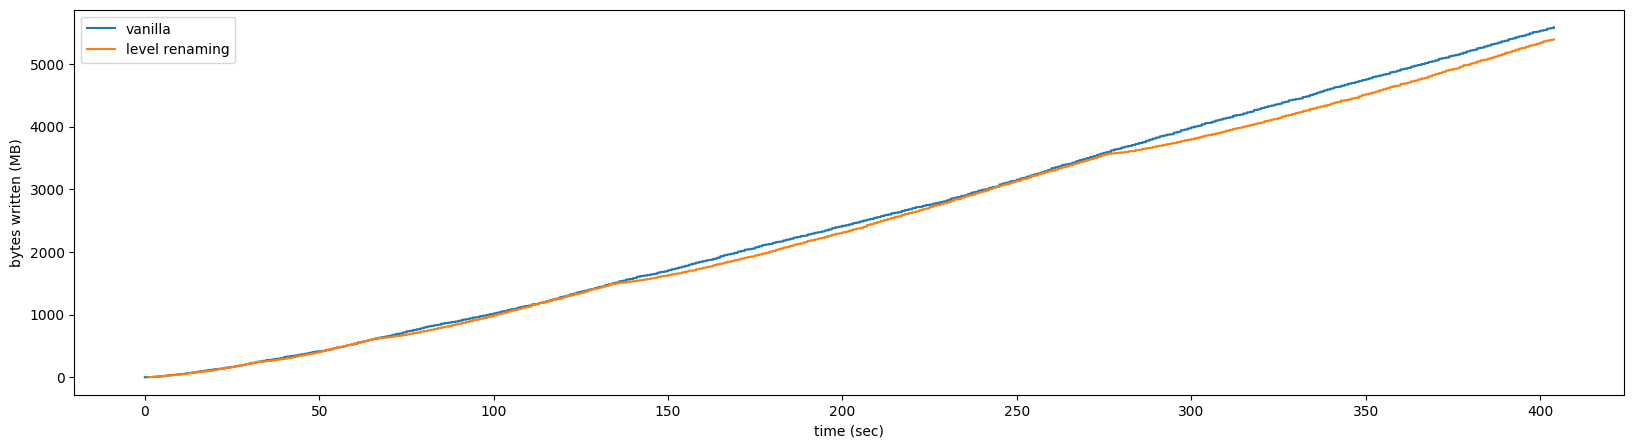

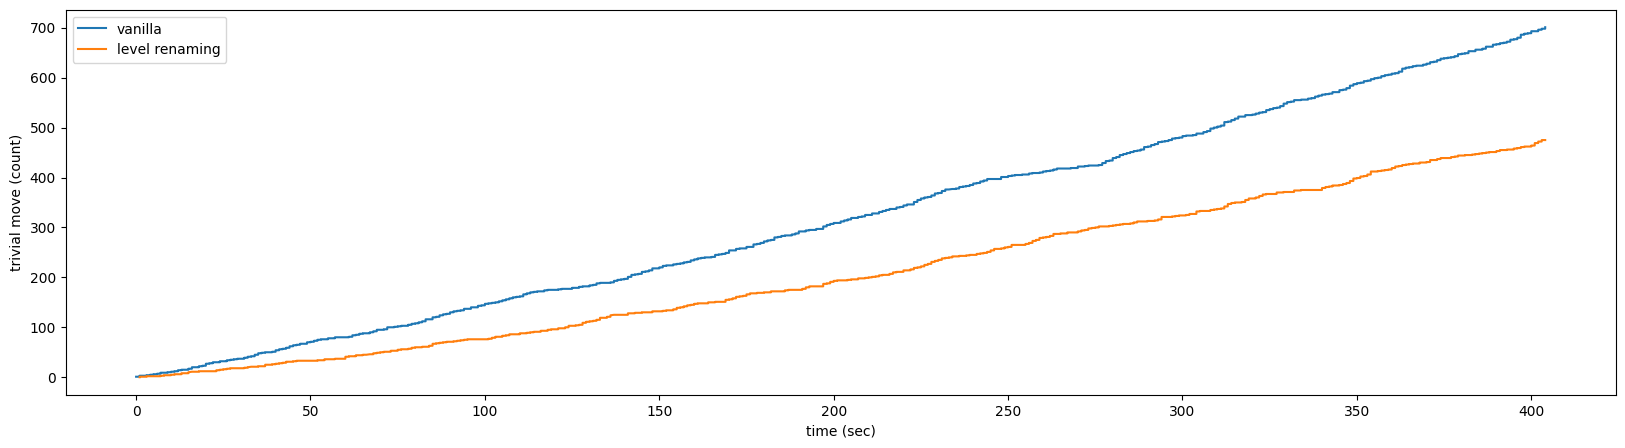

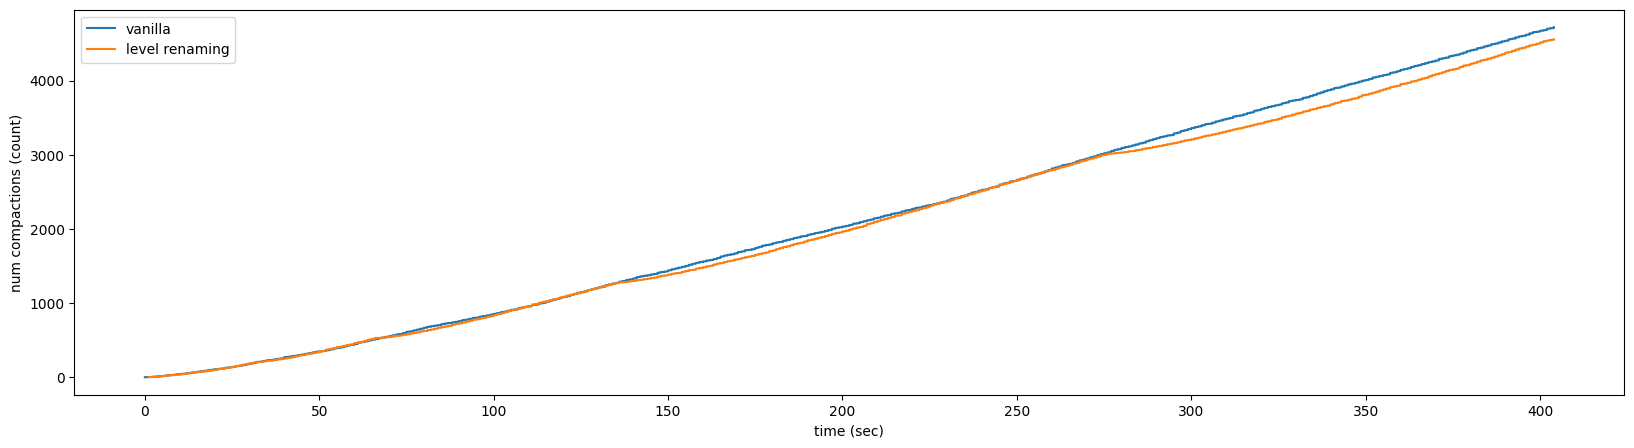

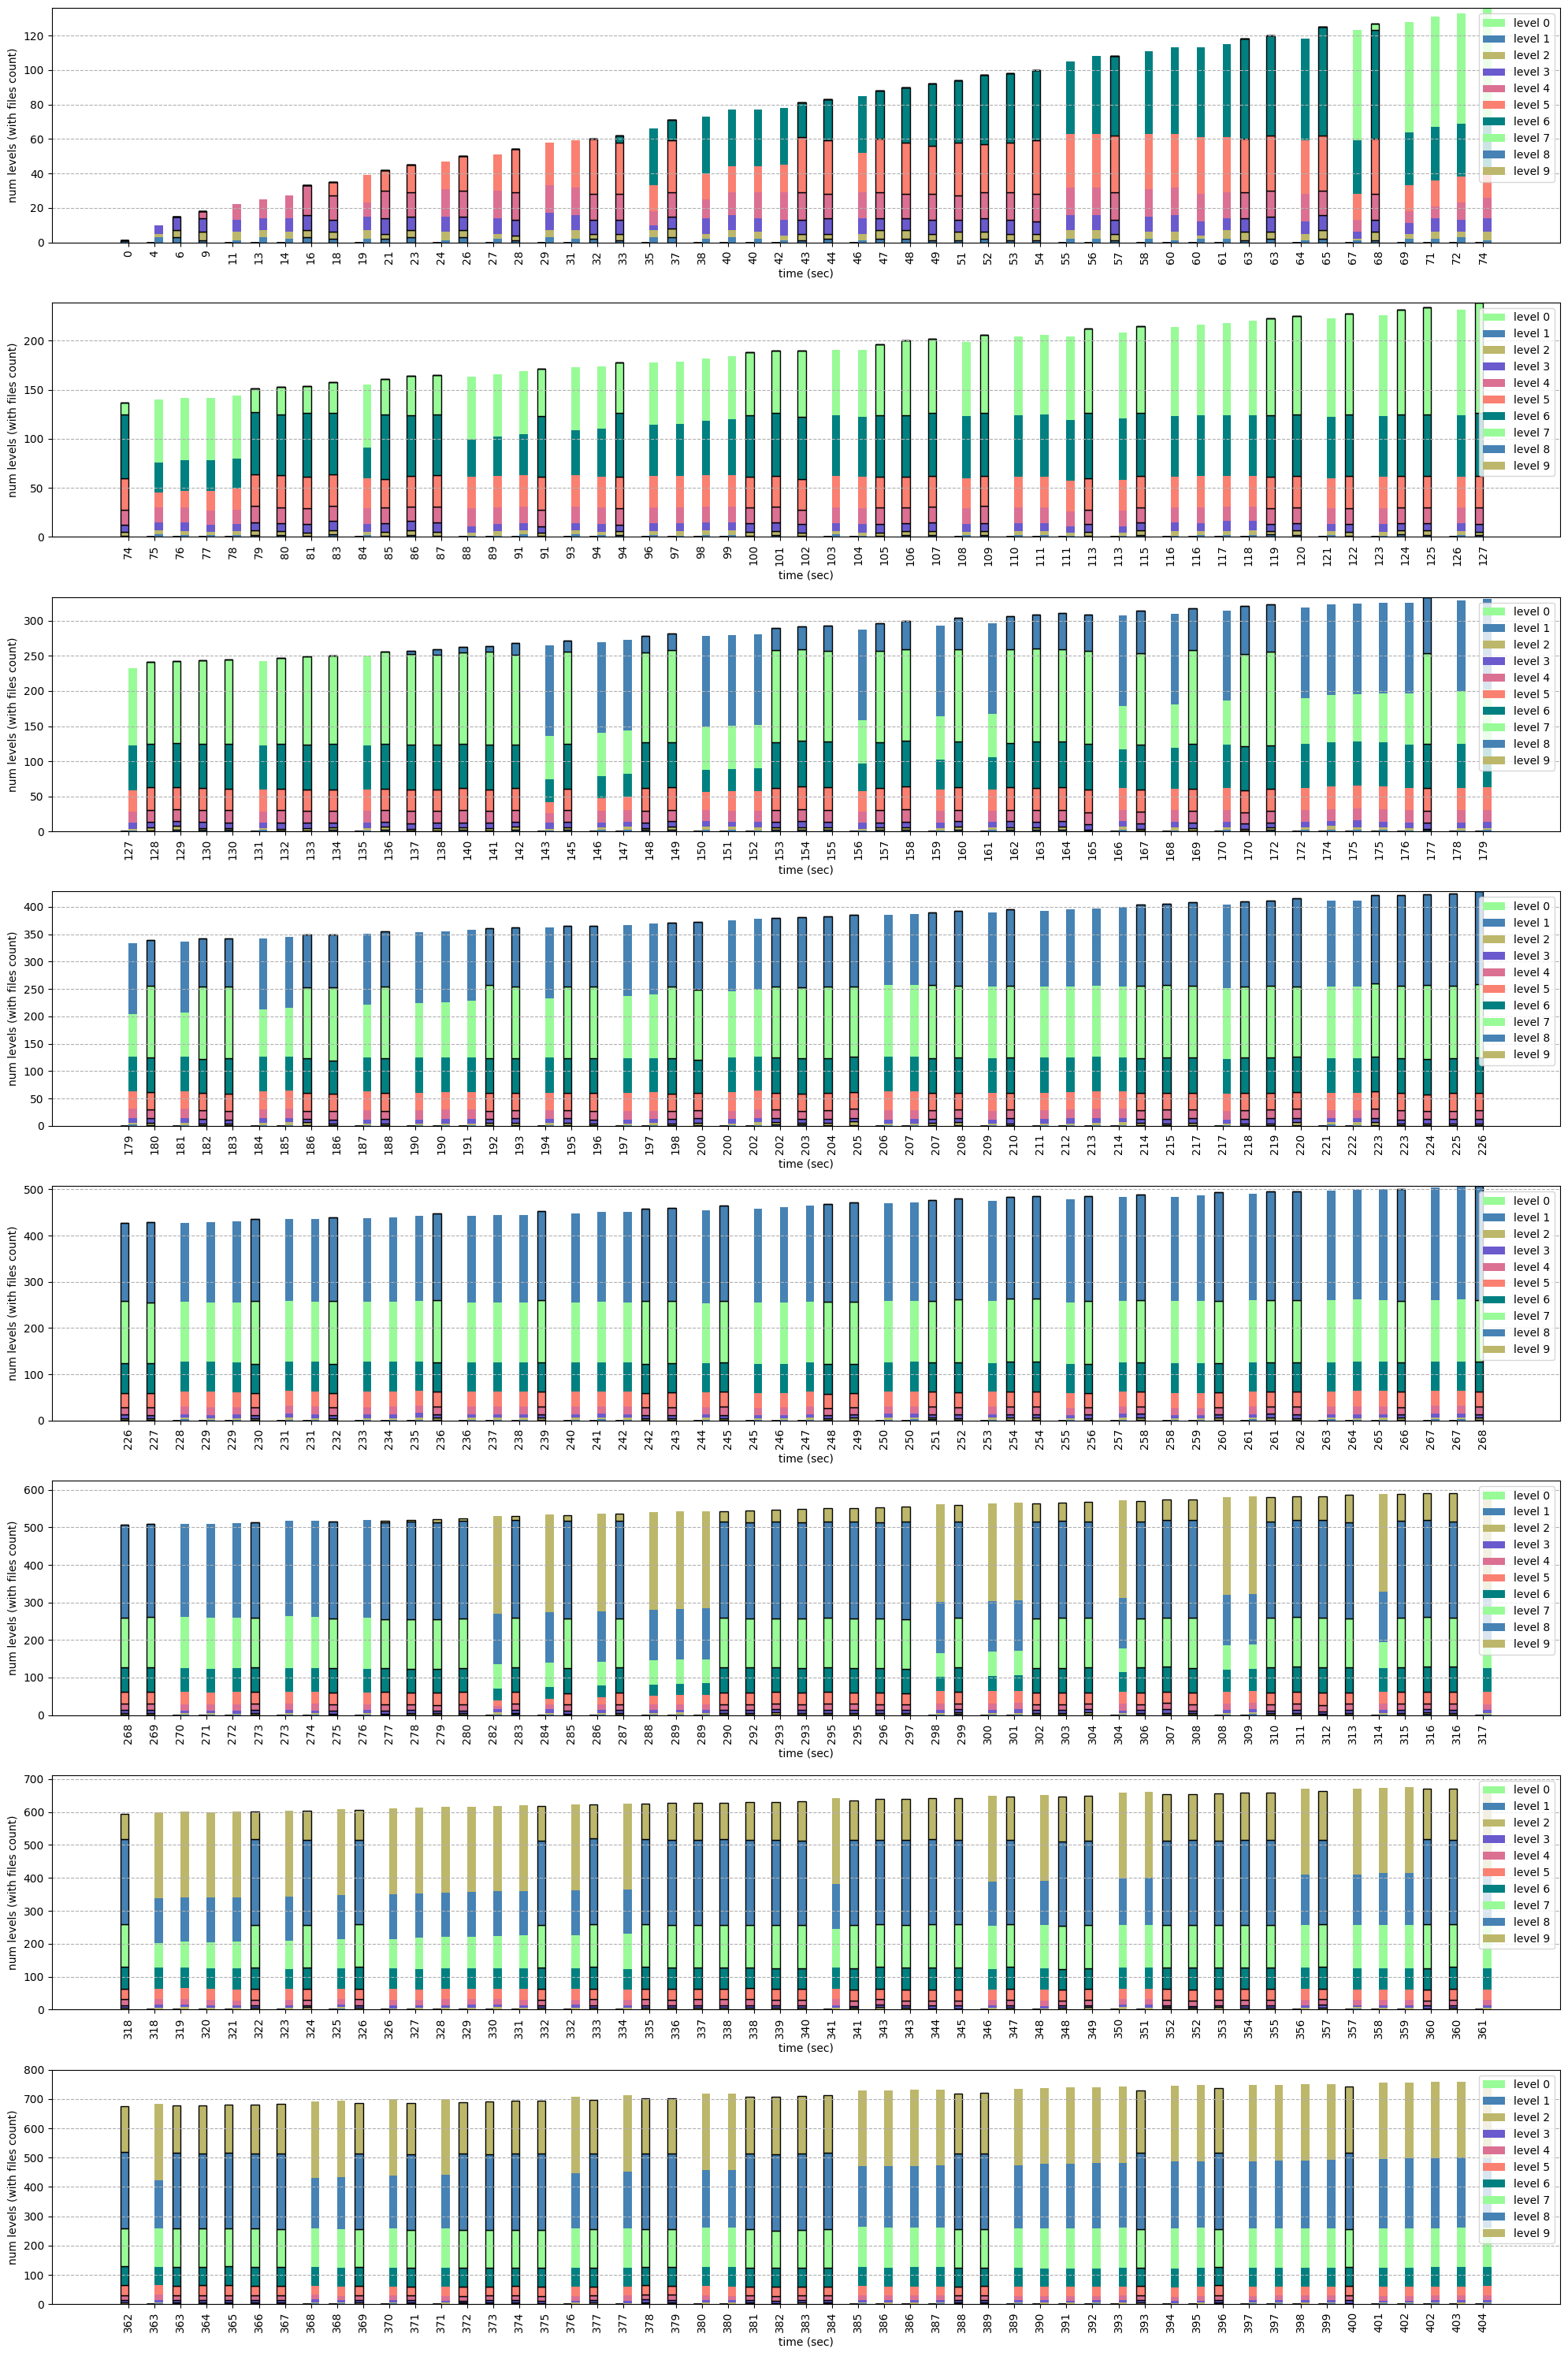

In [24]:
for exp in experiments_to_plot:
    vandirpath = os.path.join(EXPDIRNAME, vanilla_dirname(exp))
    rqdcdirpath = os.path.join(EXPDIRNAME, rqdc_dirname(exp))
    vandirpath_re_1 = os.path.join(EXPDIRNAME, vanilla_dirname(exp, re=1))
    rqdcdirpath_re_1 = os.path.join(EXPDIRNAME, rqdc_dirname(exp, re=1))

    filesize = exp["entrySize"] * exp["entriesPerPage"] * exp["numPagesPerFile"]

    van_epoch_stats = TimePoints(vandirpath)
    van_re_1_epoch_stats = TimePoints(vandirpath_re_1)
    rqdc_epoch_stats = TimePoints(rqdcdirpath)
    rqdc_re_1_epoch_stats = TimePoints(rqdcdirpath_re_1)

    plot_time_points_with_bytes_written_for_compactions(
        {
            "vanilla": van_epoch_stats.get_compactions(),
            "level renaming": van_re_1_epoch_stats.get_compactions(),
        }
    )

    plot_time_points_with_trivial_moves(
        {
            "vanilla": van_epoch_stats.get_compactions(),
            "level renaming": van_re_1_epoch_stats.get_compactions(),
        }
    )

    plot_time_points_with_num_compactions(
        {
            "vanilla": van_epoch_stats.get_compactions(),
            "level renaming": van_re_1_epoch_stats.get_compactions(),
        }
    )

    plot_time_points_with_levels(
        {
            "vanilla": van_epoch_stats.get_compactions(),
            "level renaming": van_re_1_epoch_stats.get_compactions(),
        }
    )